# Djugardens IF Hockey - Data Analysis

**Research Question:** Can we predict the total number of goals?

The data is manually scraped from this website: https://www.eliteprospects.com/team/3/djurgardens-if

**Target variable:** goals

**Predictor variables:** age, height, weight, shoots, position, games, assists, penalty_minutes, total_ratings, playoff_games, playoff_assists,playoff_penalty_minutes, playoff_total_ratings, wins, loses, ties, shootouts, time_on_ice

**Note:** These variable names are not the original names, but the updated names after the data cleaning.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, median_absolute_error, make_scorer

### Data Cleaning

In [ ]:
df = pd.read_excel("djurgardens.xlsx")

In [ ]:
# First glance to the data
df.head()

,Roster Year,Jersey Number,Nationality,First Name,Last Name,Position in Position,Age,Born,Youth Team,Height,...,GAA,SV_P,W,L,T,SO,TOI,Saves,GAAP,SVP_P
0,2004-2005,#39,Swedish,Björn,Bjurling,G,44,1979,Kista HC,183,...,2.54,.913,12,10,2,1,1442.0,643,NaN,NaN
1,2004-2005,#44,Canadian,Dan,Boyle,D,47,1976,Vanier Royals,180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-2005,#23,Swedish,Fredrik,Bremberg,LW,50,1973,IFK Tumba,183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-2005,#91,NaN,Mariusz,Czerkawski,RW,52,1972,GKS Tychy,183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-2005,#20,Swedish,Christian,Eklund,W/C,46,1977,Vendelsö IK,181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 723
Number of columns: 37


In [ ]:
# Checking for missing data
missing_counts = df.isna().sum()
for column, count in missing_counts.items():
    print("Variable:", column)
    print("Number of missing values:", count)
    print("------------------------")

Variable: Roster Year
Number of missing values: 0
------------------------
Variable: Jersey Number
Number of missing values: 4
------------------------
Variable: Nationality
Number of missing values: 481
------------------------
Variable: First Name
Number of missing values: 0
------------------------
Variable: Last Name
Number of missing values: 0
------------------------
Variable: Position in Position
Number of missing values: 0
------------------------
Variable: Age
Number of missing values: 0
------------------------
Variable: Born
Number of missing values: 0
------------------------
Variable: Youth Team
Number of missing values: 18
------------------------
Variable: Height
Number of missing values: 0
------------------------
Variable: Weight
Number of missing values: 0
------------------------
Variable: Shoots
Number of missing values: 0
------------------------
Variable: Lockout
Number of missing values: 0
------------------------
Variable: Loan
Number of missing values: 0
------

In [ ]:
# The variables we will use will be different for goaltenders, defenders, and forwarders.
# Some variables will not be applicable for some of them. therefore, some missing values here
# do not show that they are missing data, it just means the variables are not applicable.

# Inspecting further
position_counts = df['Position'].value_counts()
print(position_counts)

Position
Forward       421
Defense       228
Goaltender     74
Name: count, dtype: int64


In [ ]:
# 70 missing values in G, A, TP, PIM, and Total makes sense, as these variables are not applicable for goaltenders.
# And we have exactly 70 goaltenders!
# However, to get rid of the gaps I will put 0 in them.

columns_to_fill = ['G', 'A', 'TP', 'PIM', 'Total']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [ ]:
# GP.1, AP, TPP, PIMP, and Total_PO is all related to GPP. If the the number of missing data was equal for all,
# the missing data would refer to the absence of playoffs. However, GPP has less missing data than the rest,
# which means for some players we know they have been in playoffs, but we have no clue about their performance.

# Since it is not possible to predict it, I will just put 0 in the place of missing data. I will also convert
# the values in GPP that doesn't have further information into 0 to simplify the data.

columns_to_fill = ['GP.1', 'AP', 'TPP', 'PIMP', 'Total_PO', 'GPP']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

df.loc[df['GP.1'] == 0, 'GPP'] = 0

In [ ]:
# The variables GAA, SV_P, W, L, T, SO, TOI, and Saves are only applicable for goaltenders,
# so it makes perfect sense that they have 609 missing data, as 609 is the total number of
# defenders and forwarders in this dataset! I will still put 0 in the place of missing data
# to get rid of the gaps.

columns_to_fill = ['GAA', 'SV_P', 'W', 'L', 'T', 'SO', 'TOI', 'Saves']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [ ]:
# The variables GAAP and SVP_P are also only applicable for goaltenders, but they are playoff data.
# They have same amount of missing data, so there's no sign of actually missing data.
# Again, I will put 0 in the place of missing data.

columns_to_fill = ['GAAP', 'SVP_P']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [ ]:
# For Jersey Number and Youth Team missing data, I will put place-holders
df['Jersey Number'].fillna(999, inplace=True)
df['Youth Team'].fillna('Unknown', inplace=True)

In [ ]:
# Removing the loaned players because we are not interested in with their data
df = df[df['Loan'] != 1]

In [ ]:
# Dropping the columns that will not be needed for the analysis.
columns_to_drop = ['Nationality', 'Lockout', 'Loan']
df = df.drop(columns_to_drop, axis=1)

In [ ]:
# Making the data more workable
# in Jersey Number, getting rid of the # (only numerical value is left).
df['Jersey Number'] = df['Jersey Number'].str.replace('#', '')

# in Position in Position, getting rid of the brackets.
df['Position in Position'] = df['Position in Position'].str.replace(')', '')

In [ ]:
# Creating dummy variables to make them usable in analysis.
df['Shoots_dummy'] = df['Shoots'].replace({'R': 1, 'L': 0}).astype(int)
df['Position_dummy'] = df['Position'].replace({'Goaltender': 3, 'Defense': 2, 'Forward': 1}).astype(int)

In [ ]:
# Replacing variables with their dummy versions
df['Shoots'] = df['Shoots_dummy']
df.drop('Shoots_dummy', axis=1, inplace=True)

df['Position'] = df['Position_dummy']
df.drop('Position_dummy', axis=1, inplace=True)

In [ ]:
# Correcting the data types
print(df.dtypes)

Roster Year              object
Jersey Number            object
First Name               object
Last Name                object
Position in Position     object
Age                       int64
Born                      int64
Youth Team               object
Height                    int64
Weight                    int64
Shoots                    int64
Position                  int64
GP                        int64
G                       float64
A                       float64
TP                      float64
PIM                     float64
Total                    object
GPP                     float64
GP.1                    float64
AP                      float64
TPP                     float64
PIMP                    float64
Total_PO                float64
GAA                      object
SV_P                     object
W                        object
L                        object
T                        object
SO                       object
TOI                     float64
Saves   

In [ ]:
# Converting 'Born' into datetime format
df['Born'] = pd.to_datetime(df['Born'], format='%Y')

In [ ]:
# Inspecting further for each variable
print(df['Roster Year'].unique())

['2004-2005\xa0' '2005-2006' '2006-2007' '2007-2008' '2008-2009'
 '2009-2010' '2010-2011' '2011-2012' '2012-2013' '2013-2014' '2014-2015'
 '2015-2016' '2016-2017' '2017-2018' '2018-2019' '2019-2020' '2020-2021'
 '2021-2022' '2022-2023' '2023-2024']


In [ ]:
# There seems like an error when importing the dataset in 2004-2005.
# Fixing the error
df['Roster Year'] = df['Roster Year'].str.strip('\xa0').str.replace('', '')

In [ ]:
# Checking if it is fixed
print(df['Roster Year'].unique())

['2004-2005' '2005-2006' '2006-2007' '2007-2008' '2008-2009' '2009-2010'
 '2010-2011' '2011-2012' '2012-2013' '2013-2014' '2014-2015' '2015-2016'
 '2016-2017' '2017-2018' '2018-2019' '2019-2020' '2020-2021' '2021-2022'
 '2022-2023' '2023-2024']


In [ ]:
# Manually fixing the data type
df['Roster Year'] = df['Roster Year'].astype(str)

In [ ]:
# For second variable
print(df['Jersey Number'].unique())

# If a nan seen, the next code will give an error. In case of this problem,
# go back and rerun the placeholder code (11th codebox in this document).

['39' '44' '23' '91' '20' '3' '16' '33' '37' '25' '21' '18' '36' '4' '10'
 '17' '15' '19' '9' '6' '14' '13' '26' '60' '41' '34' '35' '30' '8' nan
 '40' '64' '28' '29' '38' '7' '70' '24' '1' '55' '84' '32' '49' '51' '78'
 '46' '56' '83' '92' '61' '66' '50' '52' '54' '59' '96' '67' '73' '63'
 '79' '77' '45' '42' '74' '48' '47' '80' '81' '76' '43' '71' '53' '31'
 '72' '62' '89' '85' '88' '86' '95' '82' '58' '90']


In [ ]:
df['Jersey Number'] = df['Jersey Number'].astype(int)

In [ ]:
df['First Name'] = df['First Name'].astype(str)
df['Last Name'] = df['Last Name'].astype(str)

In [ ]:
df['Position in Position'] = df['Position in Position'].astype(str)
df['Youth Team'] = df['Youth Team'].astype(str)

In [ ]:
# Converting the floating variables that are not supposed to be floating into integer.
df['G'] = df['G'].astype(int)
df['A'] = df['A'].astype(int)
df['TP'] = df['TP'].astype(int)
df['PIM'] = df['PIM'].astype(int)
df['GPP'] = df['GPP'].astype(int)
df['GP.1'] = df['GP.1'].astype(int)
df['AP'] = df['AP'].astype(int)
df['TPP'] = df['TPP'].astype(int)
df['Total_PO'] = df['Total_PO'].astype(int)

In [ ]:
# Inspecting the object variables
print(df['Total'].unique())

[0 4 -10 -7 2 -2 3 -1 -3 11 -9 -4 -8 1 -11 -14 -6 -17 -13 -12 6 5 -5 9 17
 12 7 8 -15 -19 22 15 16 25 18 26 '-' 19 10 13 14 20 -16 21 24]


In [ ]:
# It seems like '-' is a mistake that occured either from the data source or during scraping.
# '-' is meant to indicate 0.

df['Total'] = df['Total'].replace('-', 0)
df['Total'] = df['Total'].astype(int)

In [ ]:
# Correcting for the same mistake seen in other variables
df['GAA'] = df['GAA'].replace('-', 0)
df['GAA'] = df['GAA'].astype(float)

df['SV_P'] = df['SV_P'].replace('-', 0)
df['SV_P'] = df['SV_P'].astype(float)

df['W'] = df['W'].replace('-', 0)
df['W'] = df['W'].astype(int)

df['L'] = df['L'].replace('-', 0)
df['L'] = df['L'].astype(int)

df['T'] = df['T'].replace('-', 0)
df['T'] = df['T'].astype(int)

df['SO'] = df['SO'].replace('-', 0)
df['SO'] = df['SO'].astype(int)

df['Saves'] = df['Saves'].replace('-', 0)
df['Saves'] = df['Saves'].astype(int)

In [ ]:
# Checking for duplicate rows
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [Roster Year, Jersey Number, First Name, Last Name, Position in Position, Age, Born, Youth Team, Height, Weight, Shoots, Position, GP, G, A, TP, PIM, Total, GPP, GP.1, AP, TPP, PIMP, Total_PO, GAA, SV_P, W, L, T, SO, TOI, Saves, GAAP, SVP_P]
Index: []

[0 rows x 34 columns]


In [ ]:
# Renaming the columns to provide better understanding

new_column_names = {
    'Roster Year': 'roster_year',
    'Jersey Number': 'jersey_number',
    'First Name': 'name',
    'Last Name': 'surname',
    'Position in Position': 'position_in_position',
    'Age': 'age',
    'Born': 'birth_year',
    'Youth Team': 'youth_team',
    'Height': 'height',
    'Weight': 'weight',
    'Shoots': 'shoots',
    'Position': 'position',
    'GP': 'games',
    'G': 'goals',
    'A': 'assists',
    'TP': 'total_points',
    'PIM': 'penalty_minutes',
    'Total': 'total_ratings',
    'GPP': 'playoff_games',
    'GP.1': 'playoff_goals',
    'AP': 'playoff_assists',
    'TPP': 'playoff_points',
    'PIMP': 'playoff_penalty_minutes',
    'Total_PO': 'playoff_total_ratings',
    'GAA': 'goals_against',
    'SV_P': 'saves_%',
    'W': 'wins',
    'L': 'loses',
    'T': 'ties',
    'SO': 'shootouts',
    'TOI': 'time_on_ice',
    'Saves': 'saves',
    'GAAP': 'playoff_goals_against',
    'SVP_P': 'playoff_saves_%'
}

df = df.rename(columns=new_column_names)

# Verifying the new column names
print(df.columns)

Index(['roster_year', 'jersey_number', 'name', 'surname',
       'position_in_position', 'age', 'birth_year', 'youth_team', 'height',
       'weight', 'shoots', 'position', 'games', 'goals', 'assists',
       'total_points', 'penalty_minutes', 'total_ratings', 'playoff_games',
       'playoff_goals', 'playoff_assists', 'playoff_points',
       'playoff_penalty_minutes', 'playoff_total_ratings', 'goals_against',
       'saves_%', 'wins', 'loses', 'ties', 'shootouts', 'time_on_ice', 'saves',
       'playoff_goals_against', 'playoff_saves_%'],
      dtype='object')



### Variable Description

This dataset includes various metrics and attributes of ice hockey players and their performance, both in regular seasons and playoffs. Here are the details of each variable:

1. **`roster_year`** (Roster Year): The year the player was part of the team roster.
2. **`jersey_number`** (Jersey Number): The number on the player's jersey.
3. **`name`** (First Name): The player's first name.
4. **`surname`** (Last Name): The player's last name.
5. **`position_in_position`** (Specific Playing Position): Detailed playing positions within the broader categories of goalkeeper, defender, and forward, such as Center (C), Left Wing (LW), etc.
6. **`birth_year`** (Born): The year the player was born.
7. **`youth_team`** (Youth Team): The team where the player played during their youth.
8. **`height`** (Height): The player's height, typically in centimeters.
9. **`weight`** (Weight): The player's weight, typically in kilograms.
10. **`shoots`** (Preferred Shooting Hand): The hand with which the player prefers to shoot, either Left or Right.
11. **`position`** (General Position): The general playing position of the player: Goaltender, Defender, or Forward.
12. **`games`** (GP - Games Played): The total number of games played by the player.
13. **`goals`** (G - Goals Scored): Total goals scored by the player.
14. **`assists`** (A - Assists): Total assists made by the player.
15. **`total_points`** (TP - Total Points): Aggregate of goals and assists by the player.
16. **`penalty_minutes`** (PIM - Penalty Minutes): Total minutes the player has been penalized.
17. **`total_ratings`** (Total +/-): The plus/minus rating of the player during the season.
18. **`playoff_games`** (GPP - Games Played in Playoffs): Number of playoff games played by the player.
19. **`playoff_goals`** (GP - Goals in Playoffs): Goals scored by the player during playoffs.
20. **`playoff_assists`** (AP - Assists in Playoffs): Assists made by the player during playoffs.
21. **`playoff_points`** (TPP - Total Points in Playoffs): Total points scored by the player during playoffs.
22. **`playoff_penalty_minutes`** (PIMP - Penalty Minutes in Playoffs): Penalty minutes received by the player during playoffs.
23. **`playoff_total_ratings`** (Total PO +/- in Playoffs): The plus/minus rating of the player during the playoffs.
24. **`goals_against`** (GAA - Goals Against Average): Average goals scored against a goaltender per game.
25. **`saves_%`** (SV% - Saves Percentage): The percentage of shots stopped by a goaltender.
26. **`wins`** (W - Wins): Total games won by a goaltender.
27. **`loses`** (L - Losses): Total games lost by a goaltender.
28. **`ties`** (T - Ties): Total games tied by a goaltender.
29. **`shootouts`** (SO - Shootouts): Total shootouts where the goaltender was involved.
30. **`time_on_ice`** (TOI - Time on Ice): Total time a goaltender has spent on the ice.
31. **`saves`** (Saves): Total saves made by a goaltender.
32. **`playoff_goals_against`** (GAAP - Goals Against Average in Playoffs): Average goals scored against the goaltender during playoffs.
33. **`playoff_saves_%`** (SVP_P - Saves Percentage in Playoffs): The saves percentage of a goaltender during playoffs.

### Data Scaling

In [ ]:
# Scaling the data as helps to ensure that the features with different scales or units
# have equal importance and no features dominate the learning process in our models.

# Dropping the columns that won't need scaling
columns_to_drop = [
    'roster_year', 'jersey_number', 'name', 'surname',
    'position_in_position', 'birth_year', 'youth_team',
    'height', 'shoots', 'position'
]

# Creating a new DataFrame by dropping specified columns from the original DataFrame
df_features = df.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 679 entries, 0 to 722
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      679 non-null    int64  
 1   weight                   679 non-null    int64  
 2   games                    679 non-null    int64  
 3   goals                    679 non-null    int64  
 4   assists                  679 non-null    int64  
 5   total_points             679 non-null    int64  
 6   penalty_minutes          679 non-null    int64  
 7   total_ratings            679 non-null    int64  
 8   playoff_games            679 non-null    int64  
 9   playoff_goals            679 non-null    int64  
 10  playoff_assists          679 non-null    int64  
 11  playoff_points           679 non-null    int64  
 12  playoff_penalty_minutes  679 non-null    float64
 13  playoff_total_ratings    679 non-null    int64  
 14  goals_against            679 no

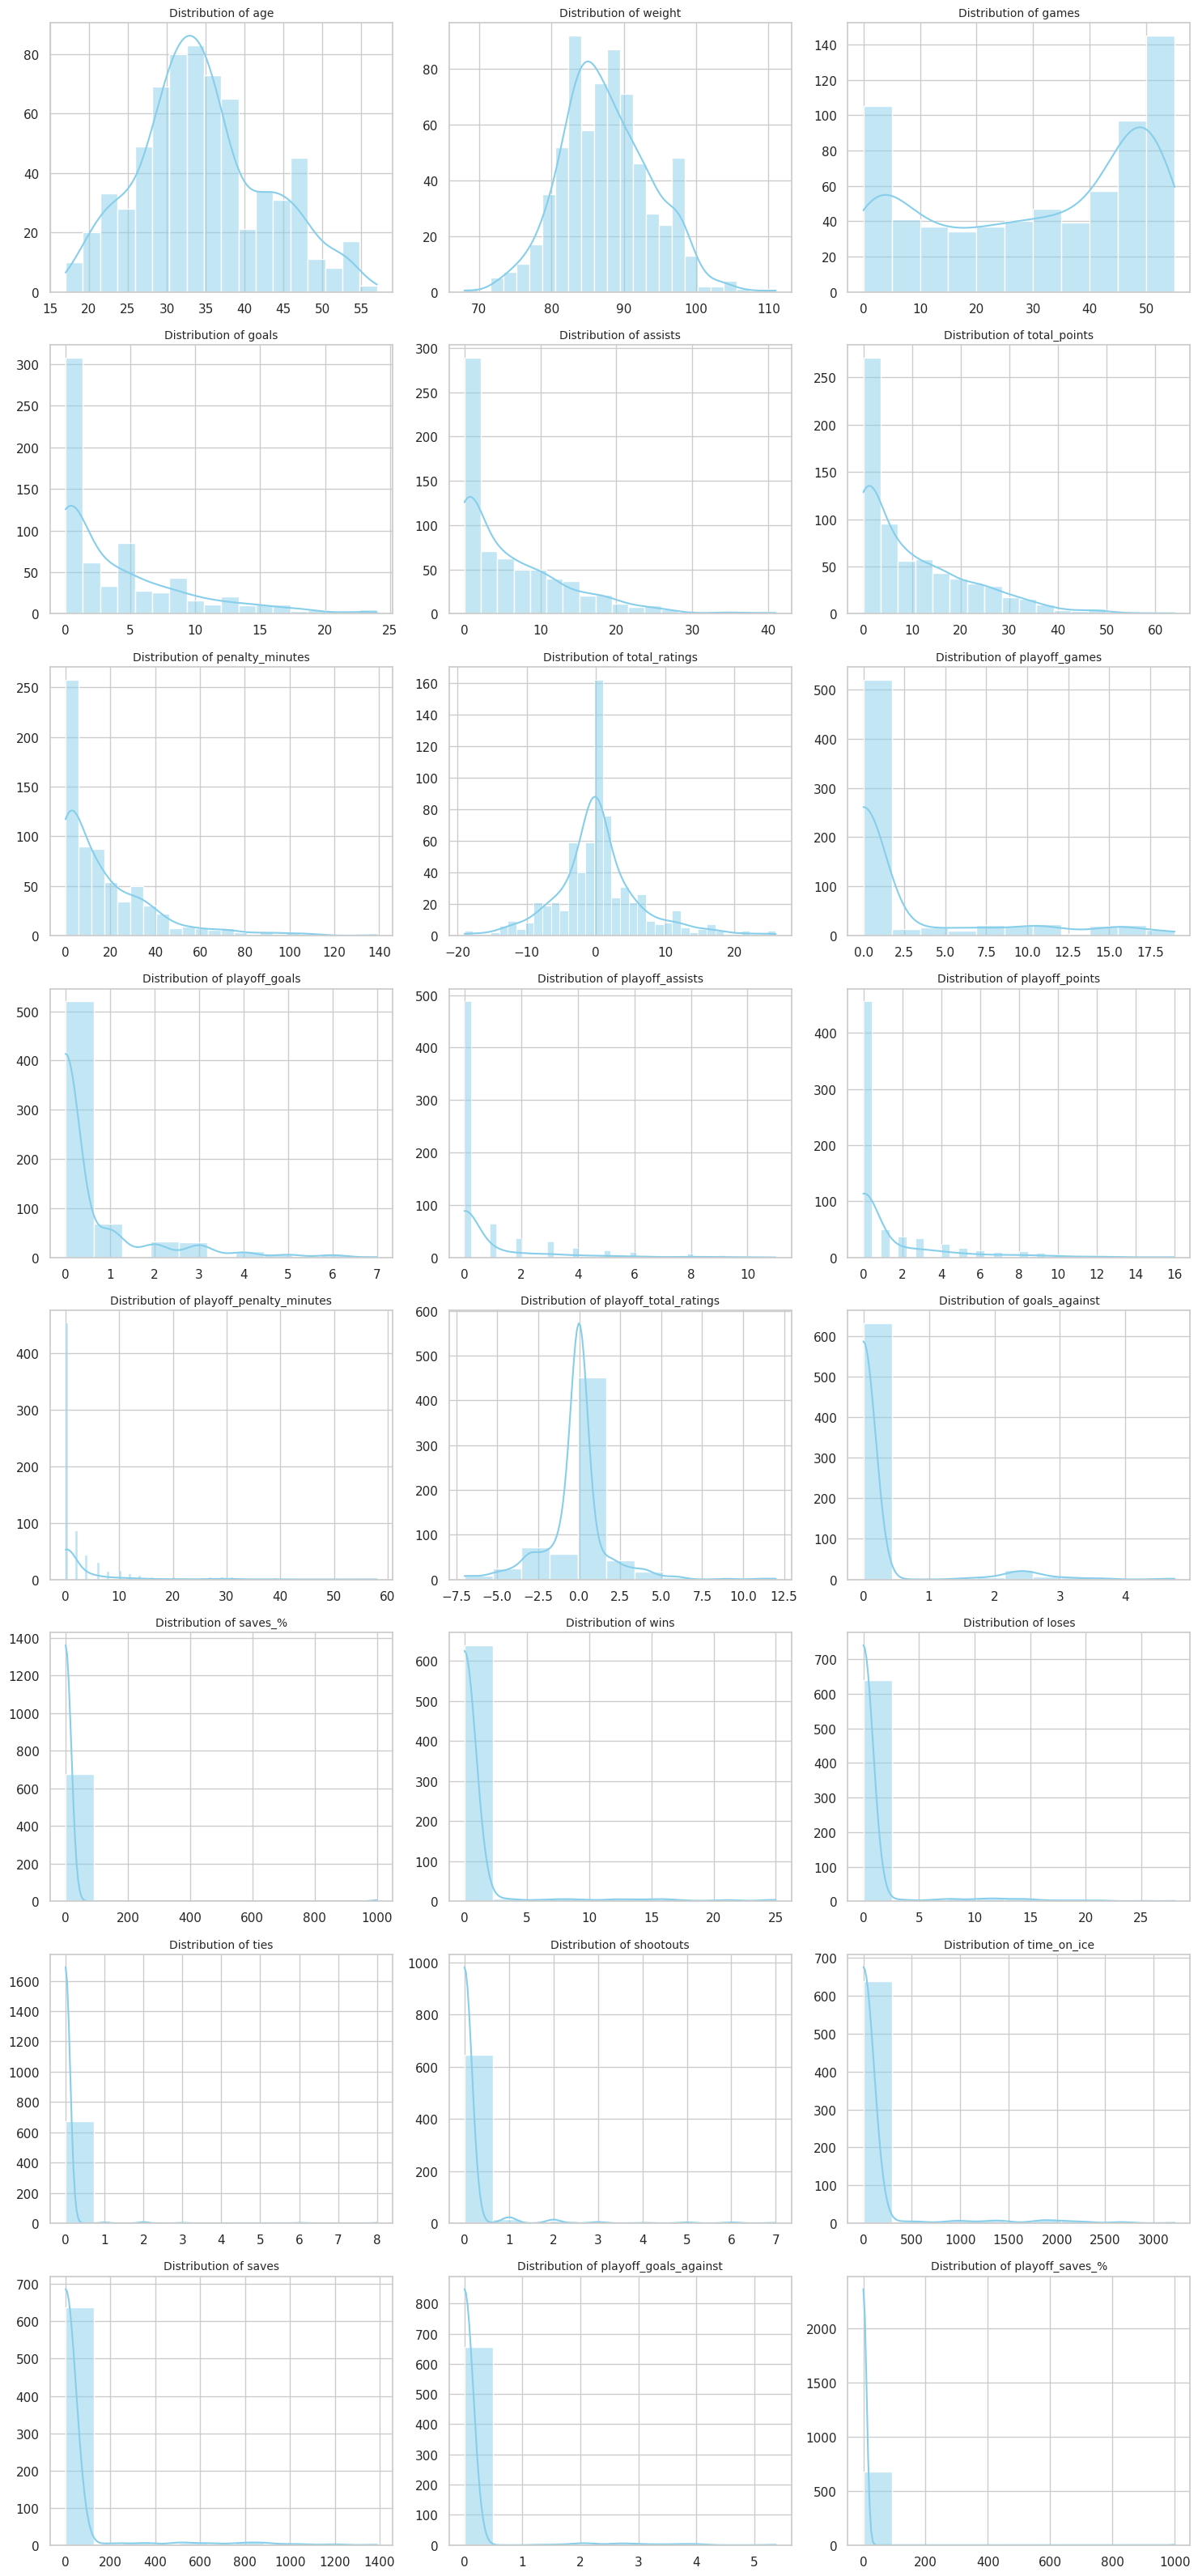

In [ ]:
# Starting with visualisation as it allows to gain insights into the distribution,
# patterns, and potential outliers in our data, which can inform our scaling strategy and preprocessing decisions.

sns.set(style='whitegrid')


def plot_histograms(data):
    num_vars = data.shape[1]
    cols = 3
    rows = (num_vars + cols - 1) // cols

    # Creating a figure object
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    # Plotting each feature
    for i, col in enumerate(data.columns):
        sns.histplot(data[col], ax=axes[i], kde=True, color='skyblue')
        axes[i].set_title(f'Distribution of {col}', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Removing unused subplots
    for i in range(num_vars, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_histograms(df_features)

In [ ]:
# The data seems quite skewed, therefore I will use Robust Scaling to make it less sensitive for outliers.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

# Extracting column names from df_features to be used for scaling
feature_columns = df_features.columns.tolist()

# Initialising the RobustScaler
scaler = RobustScaler()

# Fitting and transforming the features in df using the columns extracted from df_features
df_scaled = scaler.fit_transform(df[feature_columns])

# Replacing the original columns in df with the scaled data
df[feature_columns] = df_scaled

# Printing the updated DataFrame
print(df.head())

  roster_year  jersey_number       name      surname position_in_position  \
0   2004-2005             39      Björn    Bjurling                     G   
1   2004-2005             44        Dan       Boyle                     D   
2   2004-2005             23    Fredrik    Bremberg                    LW   
3   2004-2005             91    Mariusz  Czerkawski                    RW   
4   2004-2005             20  Christian       Eklund                  W/C   

   age birth_year     youth_team  height  weight  ...  goals_against  saves_%  \
0  1.0 1979-01-01       Kista HC     183   0.750  ...           2.54    0.913   
1  1.3 1976-01-01  Vanier Royals     180   0.125  ...           0.00    0.000   
2  1.6 1973-01-01      IFK Tumba     183   0.500  ...           0.00    0.000   
3  1.8 1972-01-01      GKS Tychy     183   0.375  ...           0.00    0.000   
4  1.2 1977-01-01    Vendelsö IK     181  -0.125  ...           0.00    0.000   

   wins  loses  ties  shootouts  time_on_ice  save

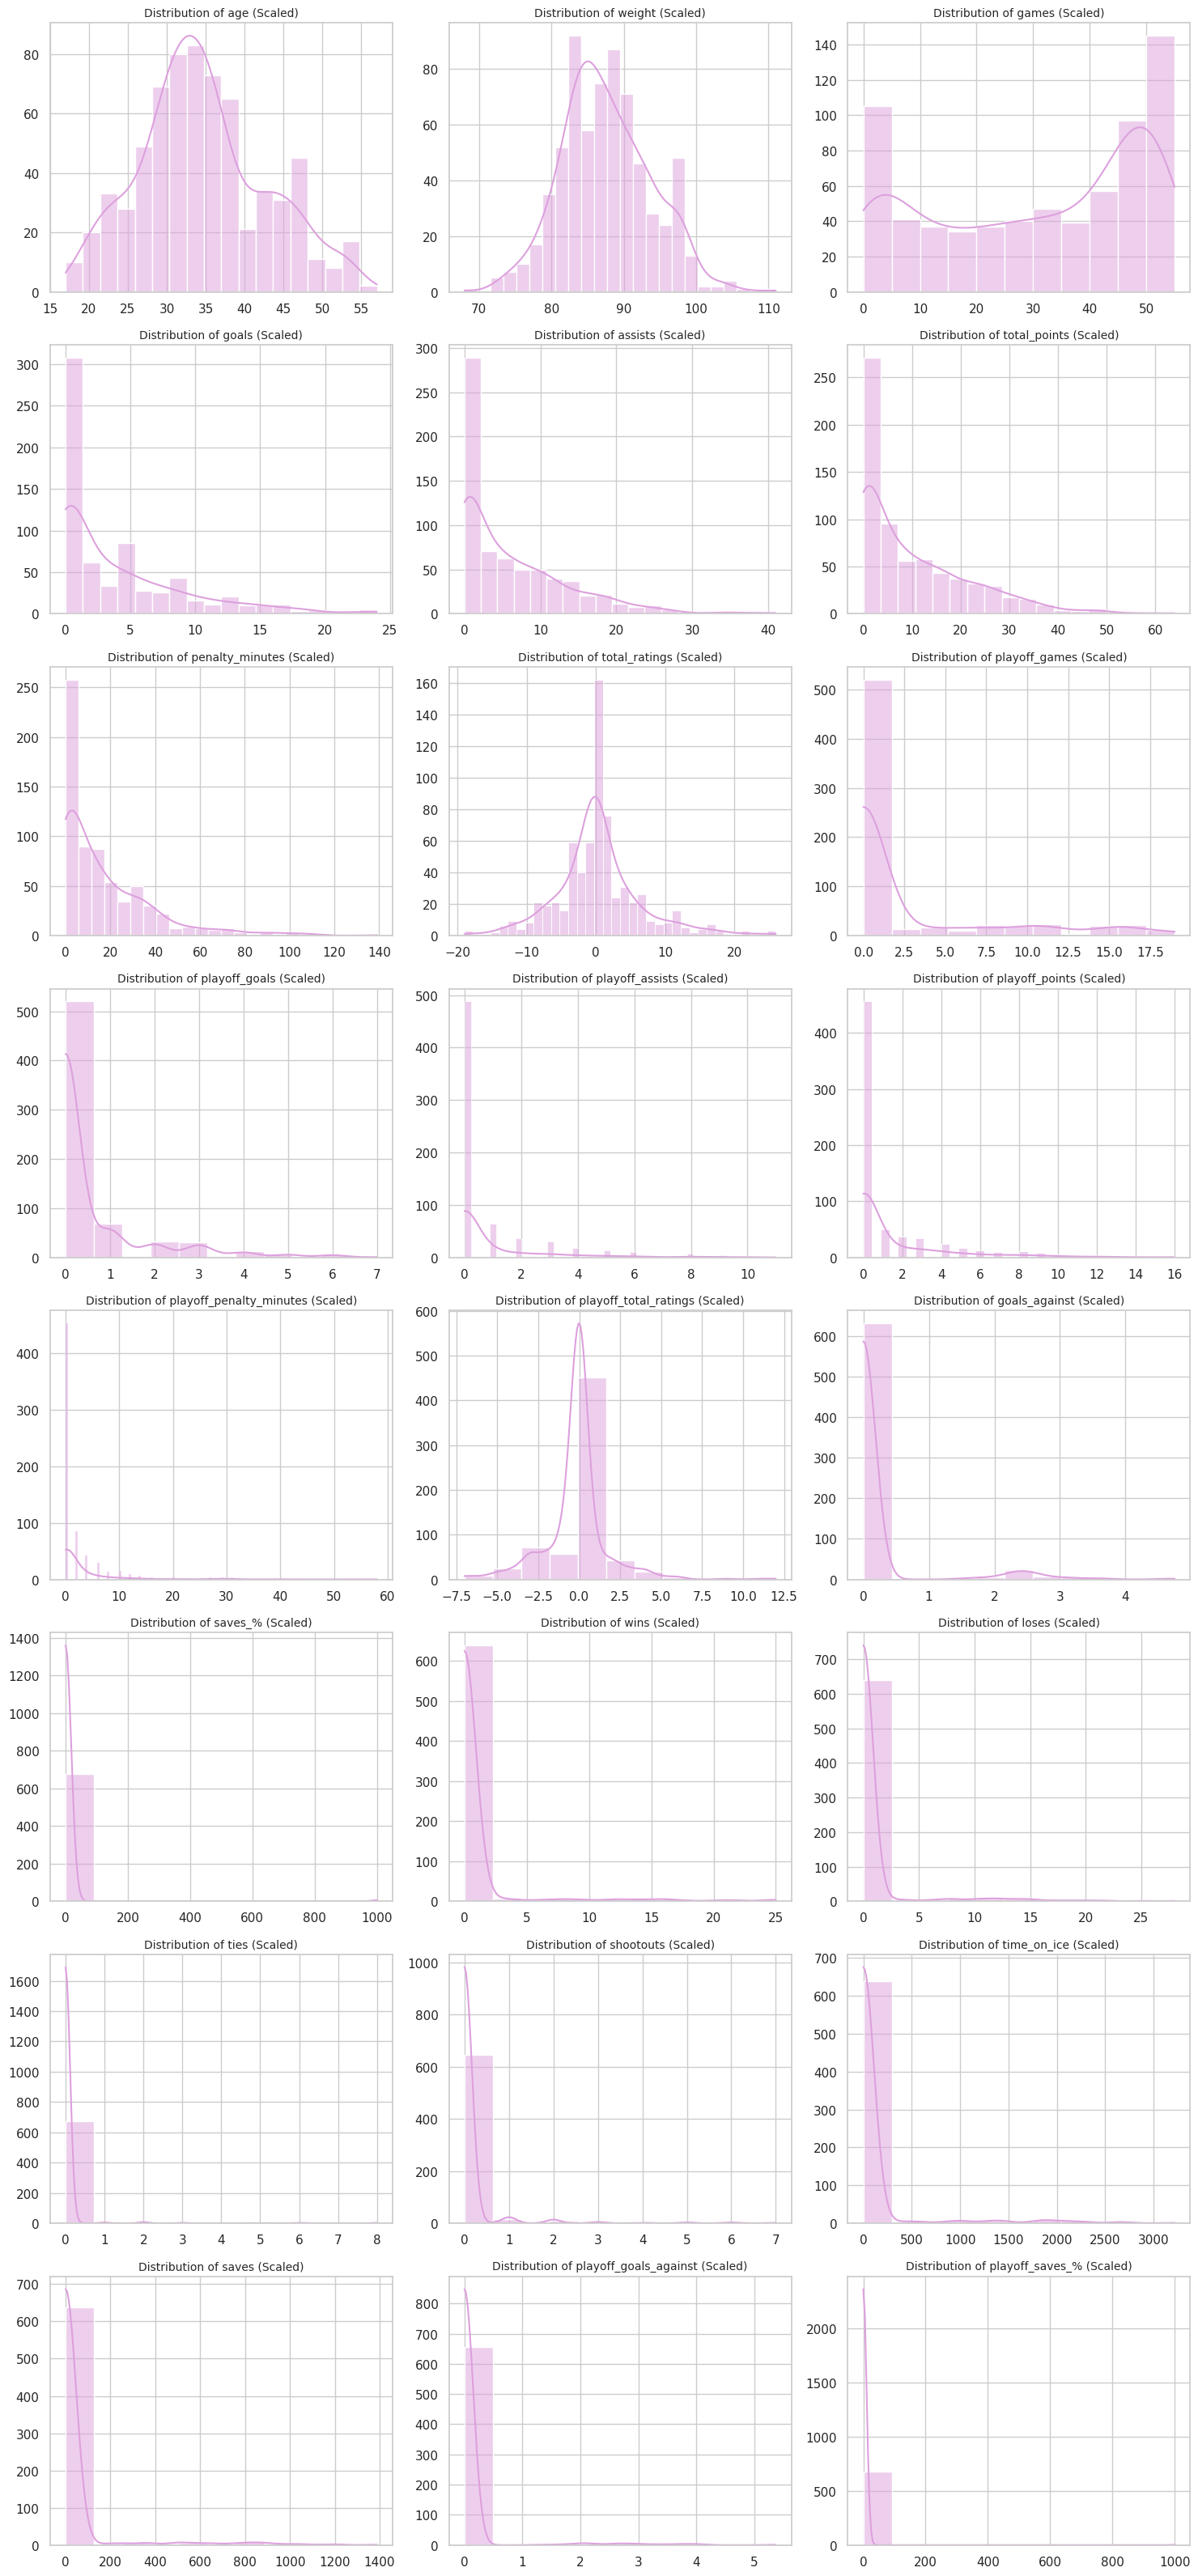

In [ ]:
# Reinspecting the data visually through histograms

sns.set(style='whitegrid')


def plot_histograms(data):
    num_vars = data.shape[1]
    cols = 3
    rows = (num_vars + cols - 1) // cols

    # Creating a figure object
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    # Plotting each feature
    for i, col in enumerate(data.columns):
        sns.histplot(data[col], ax=axes[i], kde=True, color='plum')
        axes[i].set_title(f'Distribution of {col} (Scaled)', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Removing unused subplots
    for i in range(num_vars, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_histograms(df_features)

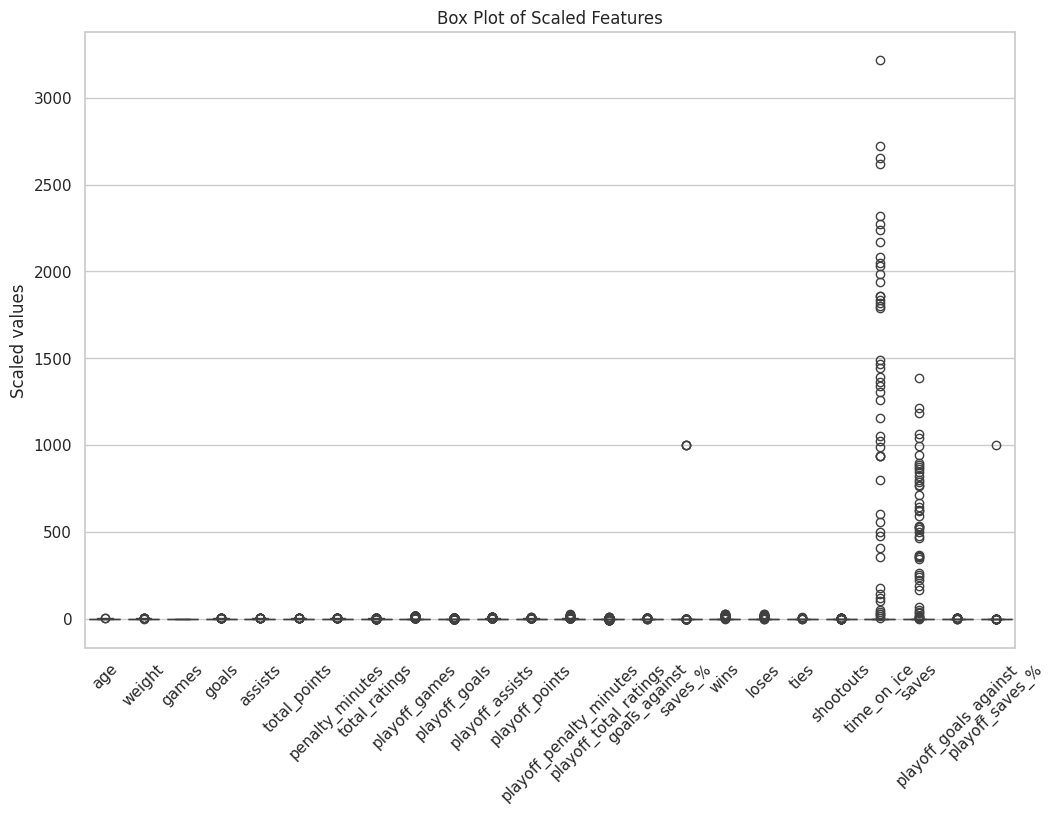

In [ ]:
# The data is still quite skewed, there is no much change in terms of visuals but scaling
# will help to handle it better

# Plotting boxplots to better see the outliers

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[feature_columns])
plt.xticks(rotation=45)
plt.title('Box Plot of Scaled Features')
plt.ylabel('Scaled values')
plt.show()

In [ ]:
# There seems to be some outliers. I will investigate them individually.

for column in feature_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Outliers for {column}:\n{outliers}")

Outliers for age:
  roster_year  jersey_number    name    surname position_in_position  age  \
8   2004-2005             37  Rikard   Franzén                     D  2.2   
9   2004-2005             25  Mikael  Johansson                    C  2.3   

  birth_year   youth_team  height  weight  ...  goals_against  saves_%  wins  \
8 1968-01-01     Vårby SK     178  -0.125  ...            0.0      0.0   0.0   
9 1966-01-01  Huddinge IK     178   0.000  ...            0.0      0.0   0.0   

   loses  ties  shootouts  time_on_ice  saves  playoff_goals_against  \
8    0.0   0.0        0.0          0.0    0.0                    0.0   
9    0.0   0.0        0.0          0.0    0.0                    0.0   

   playoff_saves_%  
8              0.0  
9              0.0  

[2 rows x 34 columns]
Outliers for weight:
    roster_year  jersey_number     name    surname position_in_position  age  \
7     2004-2005             33   Daniel  Fernholm                     D  0.6   
68    2006-2007          

A large number of outliers in multiple variables seen even after the scaling, which could reflect the wide range of variability inherent in sports performance. These outliers could be indicative of the exceptional skill levels and achievements of certain players and are thus retained to ensure a realistic and comprehensive representation of player capabilities, ensuring that our analysis and subsequent insights encompass the full diversity of player performance.

### Exploratory Data Visualisation

In [ ]:
# Pivot table grouped by roster_year that aggregates typical Ice Hockey statistics.

pivot_table = df.pivot_table(
    index='roster_year',
    values=['games', 'goals', 'assists', 'total_points'],
    aggfunc='sum'
)

# Styling: https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html
styled_pivot = pivot_table.style.background_gradient(cmap='viridis') \
    .format("{:.2f}") \
    .set_properties(**{'border': '1.5px solid black'}) \
    .highlight_max(color='salmon') \
    .highlight_min(color='lightgreen')

display(styled_pivot)

,assists,games,goals,total_points
roster_year,,,,
2004-2005,7.10,-2.19,11.33,8.42
2005-2006,5.60,-1.65,10.00,7.03
2006-2007,10.40,0.37,13.33,11.15
2007-2008,8.60,-0.61,10.50,9.03
2008-2009,10.50,-2.51,12.00,10.73
2009-2010,11.40,-1.87,13.17,11.70
2010-2011,4.90,-3.76,9.50,6.42
2011-2012,5.20,0.03,8.67,6.30
2012-2013,8.60,-4.59,13.00,9.94


Interpretation of the pivot table:
*   The number of games played each season hovers around 1000, with some variations. Notably, the 2012–2013 season shows a significantly lower number of games (1022), which could indicate a shortened season or fewer teams/players contributing to the statistics.
*   The highest number of assists recorded in a single season is 259 during the 2009–2010 season, while the lowest is 165 in the 2016–2017 season.
*   The highest number of goals is seen in the 2005–2006 season (130 goals), and the lowest number of goals scored is in the 2016–2017 season (103 goals).
*   Total points peaked in the 2009–2010 season (397 points) and were at their lowest in the 2016–2017 season (268 points).
*   The most recent season, 2023–2024, shows a significant increase in both assists and goals compared to the previous season, resulting in one of the higher total points (390) over the periods presented.

Note that this table uses the standardised data and only aims for the visualisation of the concepts. If we wanted to gather information regarding certain numbers, we would need to check the unstandardised data.

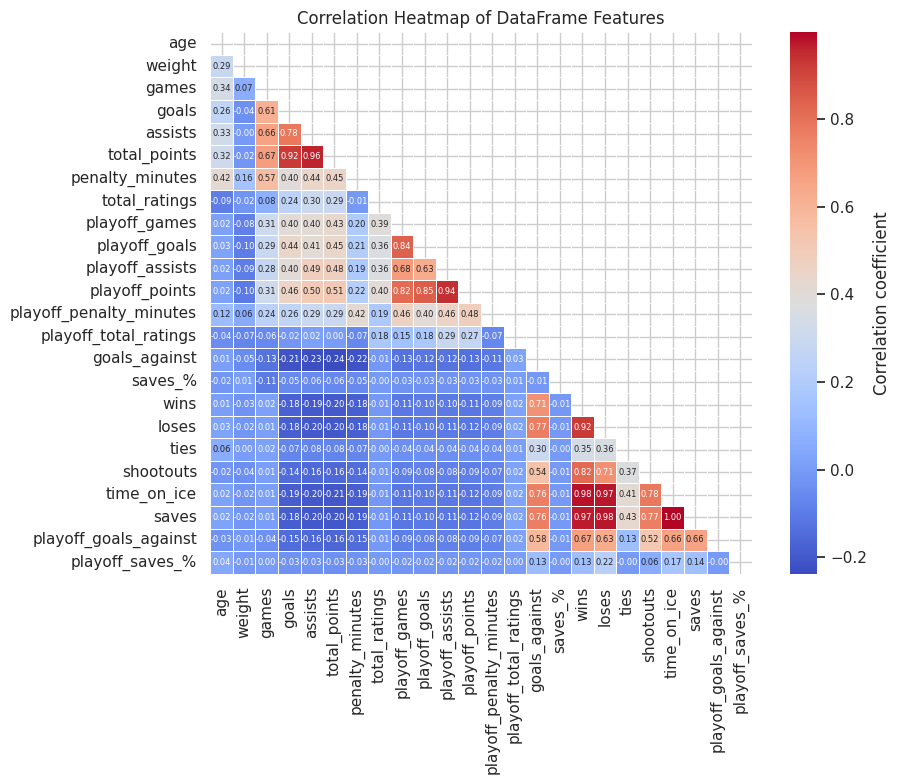

In [ ]:
# Creating a correlation heatmap to explore the relationship between different columns
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

correlation_matrix = df_features.corr()

plt.figure(figsize=(10, 8))

# Generating a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Drawing the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, square=True,
            linewidths=0.5, linecolor='white', annot_kws={"size": 6})

plt.title('Correlation Heatmap of DataFrame Features')

plt.tight_layout()

plt.show()

The interpretation of the heatmap:

High Positive Correlations:
*   There is a strong positive correlation between games and total_points (0.97), indicating that as the number of games increases, the total points tend to increase as well.
*   goals and assists are highly correlated (0.78), suggesting that players who score more goals also tend to have more assists.
*   total_points has strong correlations with goals (0.96) and assists (0.97), which is expected as total points are often a sum of goals and assists.
*   There is also a significant correlation between playoff_points and playoff_goals (0.84), as well as playoff_points and playoff_assists (0.94), indicating similar relationships in playoff performance metrics as with regular season.
*   wins and saves have a high correlation (0.92), which could indicate that goalies who make more saves contribute to more wins, or that teams that win often force goalies to make more saves.

Moderate Positive Correlations:
*   weight has a moderate correlation with penalty_minutes (0.57), which might imply that heavier players are more likely to spend more time in the penalty box.
*   playoff_goals and playoff_assists are moderately correlated (0.63), though not as strongly as their regular season counterparts.

Low to Negligible Correlations:
*   age shows a very low correlation with most of the performance-related features, suggesting that age is not a strong predictor of performance metrics like goals, assists, or total points in this dataset.
*   shootouts have low correlations with most other features, which could indicate that shootouts are relatively independent events within the context of the other recorded statistics.

Negative Correlations:
*   There are no strong negative correlations present in the heatmap. However, there are some features with low negative correlations, such as goals_against and saves (-0.03), which is somewhat counterintuitive as one might expect goalies with more saves to allow fewer goals. This weak correlation suggests that other factors might be influencing these metrics.

In [ ]:
# To inspect more visuals faster, let's use a library called Lux that offers visuals automation.
# https://github.com/lux-org/lux?tab=readme-ov-file

# For this, we will need to save the cleaned data as a new file. Otherwise, the Lux Toggle Widget is not visible.
df.to_excel('djurgardens_cleaned.xlsx', index=False)

In [ ]:
# Installing Lux
!pip install lux

In [ ]:
import lux

# To see the widget in Google Colab: https://github.com/lux-org/lux/issues/169
from google.colab import output
output.enable_custom_widget_manager()

df_lux = pd.read_excel('djurgardens_cleaned.xlsx')
df_lux

When we click the Toggle Pandas/Lux box above and wait a little bit, we get a cool attachment with various visuals. We could see all correlations summarised in the heatmap individually as a scatterplot, or check for occurences and temporals. See how varied the youth_team is! Apparently Djurgardens IF is a diverse team in terms of its players' previous teams. Or check for the temporal graph, seems like the birth year for the players is kind of centered around 1990.  

### Data Analysis

In [ ]:
# In this section, a model will be trained to predict a player's number of goals scored based on other variables.
# As this is not applicable to goaltenders, they will be removed.

df_no_gt = df[df["position"] != 3]

In [ ]:
# Now, let's compare several models to identify which ML algorithm would fit best in our data.
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

# We will not include any of the columns that exclusively
# apply to goaltenders, as the values for these variables are zero anyway.
# The columns for playoff goals and total points (goals + assists) will also not be used because
# they are measuring the same thing we are trying to predict.

X = df_no_gt[[
    "age", "height", "weight", "shoots", "position", "games", "assists", "penalty_minutes",
    "total_ratings", "playoff_games", "playoff_assists", "playoff_penalty_minutes",
    "playoff_total_ratings", "wins", "loses", "ties", "shootouts", "time_on_ice"
]]
y = df_no_gt['goals']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Creating a function to evaluate models according to their r2 value.
def evaluate_model(model):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()

In [ ]:
# SVM
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_score = evaluate_model(svm_model)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_score = evaluate_model(xgb_model)

# Linear Regression
lr_model = LinearRegression()
lr_score = evaluate_model(lr_model)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_score = evaluate_model(rf_model)

In [ ]:
models = [
    ('SVM', svm_model, svm_score),
    ('XGBoost', xgb_model, xgb_score),
    ('Linear Regression', lr_model, lr_score),
    ('Random Forest', rf_model, rf_score)
]

models.sort(key=lambda x: x[2], reverse=True)

print("Model Rankings:")
for i, (name, model, score) in enumerate(models, start=1):
    print(f"{i}. {name}: R2 Score = {score:.4f}")
    print(f"   Parameters: {model.get_params()}\n")

Model Rankings:
1. Linear Regression: R2 Score = 0.6573
   Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

2. Random Forest: R2 Score = 0.6408
   Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

3. XGBoost: R2 Score = 0.6373
   Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None

It seems like the Linear Regression is the best fit for our model, however the performance difference between this and the second-best fit is not that high. Since we have an opportunity to develop our model through hyperparameter tuning, we will go with Random Forest instead.

In [ ]:
# Hyperparameter tuning

#Defining the parameter grid for grid search
param_grid = {"n_estimators": [1000, 1400, 2000],
              "max_depth": [20, 40, 60],
              "min_samples_leaf": [1, 2, 3],
              "max_features": [1.0, 'sqrt', 0.5],
              "min_samples_split": [2, 5, 10]
}

# Creating the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Defining the scoring metrics
scoring = {'r2': 'r2',
           'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False)}

# Performing grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=scoring, refit='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Getting the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Random Forest Model:")
print("R2 Score: {:.4f}".format(best_score))
print("Best Parameters:", best_params)

# Evaluating the best model on the test set
best_model_score = best_model.score(X_test, y_test)
print("Best Model Test R2 Score: {:.4f}".format(best_model_score))

y_pred = best_model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
print("Best Model Test Median Absolute Error: {:.4f}".format(mae))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Random Forest Model:
R2 Score: 0.6589
Best Parameters: {'max_depth': 40, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1400}
Best Model Test R2 Score: 0.5808
Best Model Test Median Absolute Error: 0.2168


The best model found through cross-validation has an R2 score of 0.6589, which indicates that approximately 65.89% of the variance in the target variable (the total number of goals) can be explained by the features used in the model.

When evaluated on the unseen test set, the best model achieved an R2 score of 0.5808, which is lower than the cross-validation score. This suggests that the model may have overfit the training data, but still performs OK (MAE: 0.2168 with a standard deviation of 5) on new, unseen data.

Next, we will visually inspect the performance of the model and run feature importance to inspect the importance of our predictors individually.

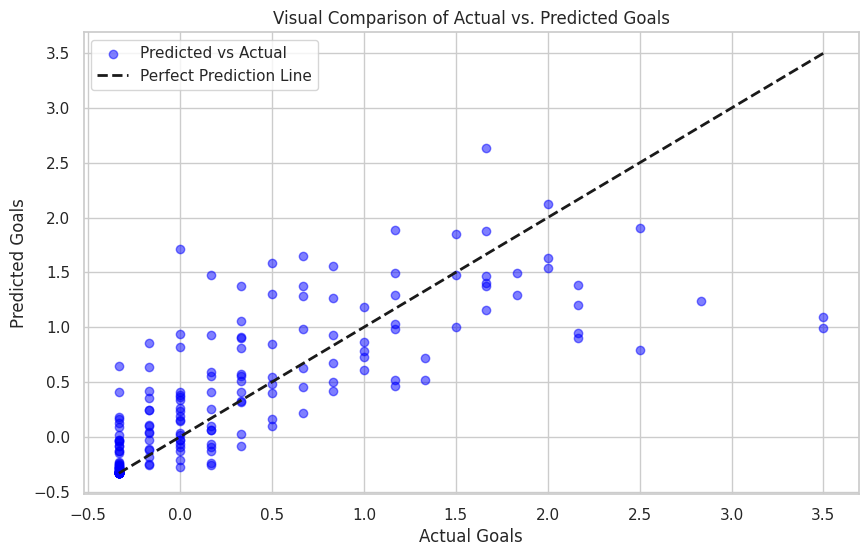

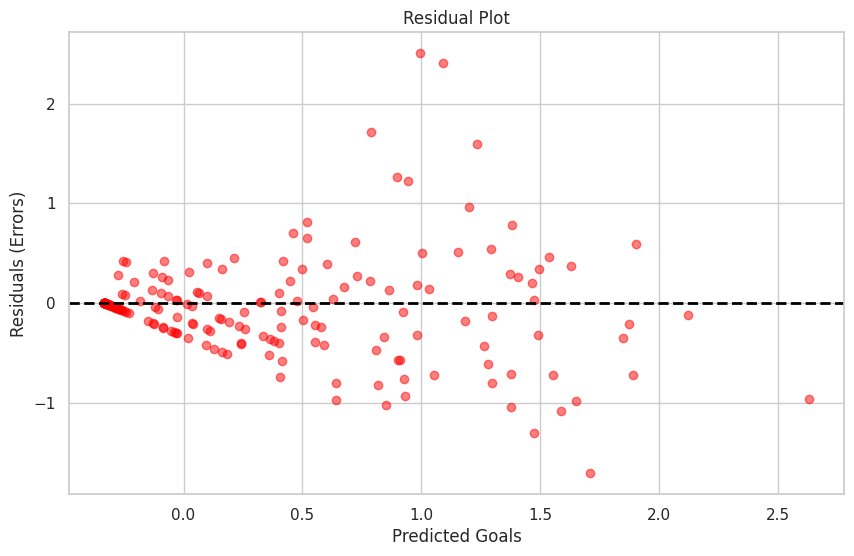

In [ ]:
# Visualising the model

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.title('Visual Comparison of Actual vs. Predicted Goals')
plt.legend()
plt.show()

# Plotting a residual plot to see the distribution of errors
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=2)
plt.xlabel('Predicted Goals')
plt.ylabel('Residuals (Errors)')
plt.title('Residual Plot')
plt.show()

Interpretation of the graphs:
*   The residuals appear to be somewhat randomly distributed around the zero line, but there is a slight pattern visible. The residuals tend to be positive for lower predicted goals and negative for higher predicted goals.
*   This suggests that the model might be slightly overestimating the goals for lower predictions and underestimating the goals for higher predictions.
However, the overall pattern of residuals is relatively close to the ideal scenario, indicating a reasonable model fit.
*   In the first graph, the blue dots are scattered around the perfect prediction line, indicating that the model's predictions are not perfect but are reasonably close to the actual values.
*   The scatter of the dots suggests that the model has considerable predictive power, as there is a positive correlation between the actual and predicted goals. It is also more successful to predict lower amount of goals, which is the case for the majority of our dataset.
*   To further improve our model, we could includd interaction terms or explore non-linear models. Enhancing the feature set to better capture dynamics at higher goal ranges could also improve predictions. Finally, using a different dataset could help verify improvements and ensure the model's robustness.

In [ ]:
# Identifying which variables explain most of the variance

feature_importances = best_model.feature_importances_

for i, feature_name in enumerate(X_train.columns):
    print(f'Feature {feature_name}: Importance {feature_importances[i]}')

Feature age: Importance 0.039786791479555036
Feature height: Importance 0.029435552470052855
Feature weight: Importance 0.030057697356017057
Feature shoots: Importance 0.007321094552990138
Feature position: Importance 0.054816531567041825
Feature games: Importance 0.1483166185714823
Feature assists: Importance 0.46870978720074374
Feature penalty_minutes: Importance 0.07675747082005817
Feature total_ratings: Importance 0.050296086552201746
Feature playoff_games: Importance 0.02655326763584805
Feature playoff_assists: Importance 0.028696701333942302
Feature playoff_penalty_minutes: Importance 0.016062760209189897
Feature playoff_total_ratings: Importance 0.023189640250876782
Feature wins: Importance 0.0
Feature loses: Importance 0.0
Feature ties: Importance 0.0
Feature shootouts: Importance 0.0
Feature time_on_ice: Importance 0.0


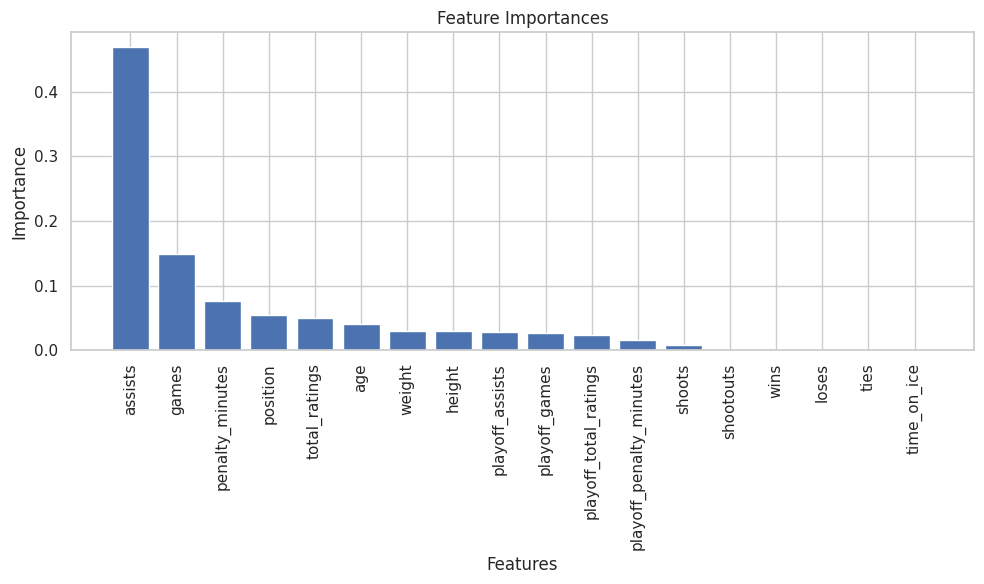

In [ ]:
# Inspecting the feature importance visually
importances = best_model.feature_importances_
feature_names = X_train.columns

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

By far the most important predictor for the number of goals is the number of assists, followed by the number of games played and the penaly minutes. While it was expected that these would be the top three most important features, we had not expected assists would be so much more important than the rest. The most important conclusion of our analysis is thus that players with many assists also tend to score many goals.